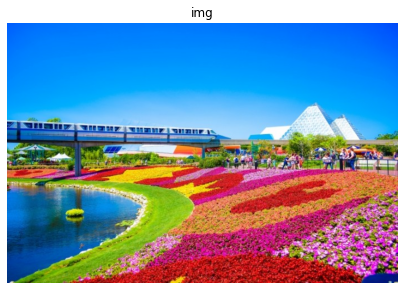

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from skimage.transform import rescale, resize, downscale_local_mean

img = cv2.imread("pic.jpg")
def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title)
    plt.show()
draw_picture(img, "img")

164131


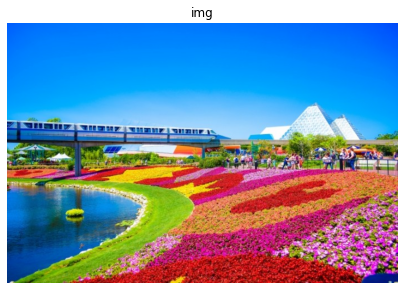

In [2]:
# складываем в одномерный массв троек
i_r = img.copy().reshape((700*466, 3))
# Исходное число цветов
_ = pd.DataFrame(i_r,dtype=np.short)
_.drop_duplicates(inplace = True, ignore_index=True)
print(len(_))
# восстанавливаем в рисунок
draw_picture(i_r.reshape((466,700, 3)), "img")

число кластеров 779
число 'шумовых' 3131
число всего 13020
ssim dbscan:
0.5556329096495239


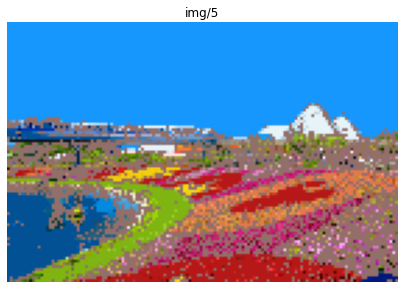

In [3]:
data = img.copy()
fraction = 5
epsilon=5
min_samples=2
# image = data
image = (resize(data, 
    (int(data.shape[0] / fraction), 
    int(data.shape[1] / fraction)),
    anti_aliasing=False)*255).astype(int)
a = DBSCAN(eps=epsilon, min_samples=min_samples).fit(image.reshape((image.shape[0]*image.shape[1], 3)))
print("число кластеров %d" % len(np.unique(a.labels_)))
print("число 'шумовых' %d" % len(a.labels_[np.where(a.labels_ == -1)]))
print("число всего %d" % len(a.labels_))
fl = image.copy().reshape((image.shape[0]*image.shape[1], 3))
b = fl.copy()
for l in np.unique(a.labels_):
    mean = np.mean(fl[np.where(a.labels_ == l)], axis=(0,)).astype(int)
    fl[np.where(a.labels_ == l)] = mean
print('ssim dbscan:')
print(ssim(
    fl.reshape((image.shape[0],image.shape[1], 3)),
    b.reshape((image.shape[0],image.shape[1], 3)),
    data_range=b.max() - b.min(),
    channel_axis=2 ))
draw_picture(fl.reshape((image.shape[0],image.shape[1], 3)), "img/%d" % (fraction))

число кластеров 5
0.5666756322866688


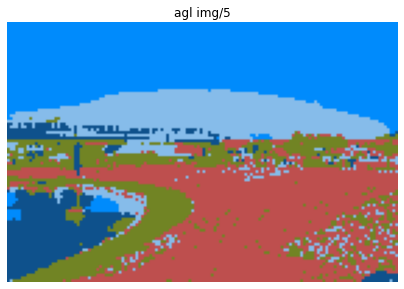

In [4]:
# image = data.copy().reshape((data.shape[0]*data.shape[1],3))
agl = AgglomerativeClustering(linkage="ward", n_clusters=5).fit(image.reshape((image.shape[0]*image.shape[1], 3)))
print("число кластеров %d" % len(np.unique(agl.labels_)))
fl = image.copy().reshape((image.shape[0]*image.shape[1], 3))
b = fl.copy()
for l in np.unique(agl.labels_):
    mean = np.mean(fl[np.where(agl.labels_ == l)], axis=(0,)).astype(int)
    fl[np.where(agl.labels_ == l)] = mean

print(ssim(
    fl.reshape((image.shape[0],image.shape[1], 3)),
    b.reshape((image.shape[0],image.shape[1], 3)),
    data_range=b.max() - b.min(),
    channel_axis=2 ))
draw_picture(fl.reshape((image.shape[0],image.shape[1], 3)), "agl img/%d" % (fraction))

In [5]:
setup = [
{
    'alg':'KMeans',    'n_clusters':2,},
{
    'alg':'KMeans',    'n_clusters':5,},
{
    'alg':'KMeans',    'n_clusters':10,},
{
    'alg':'KMeans',    'n_clusters':20,},
]

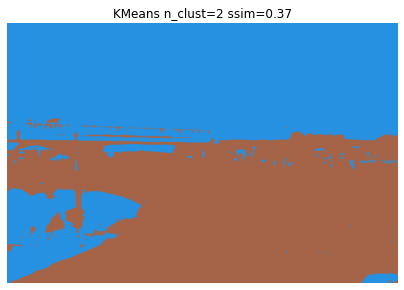

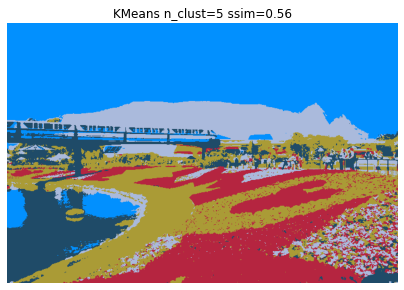

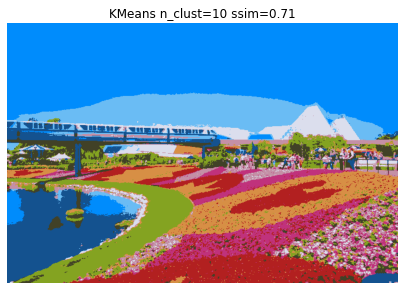

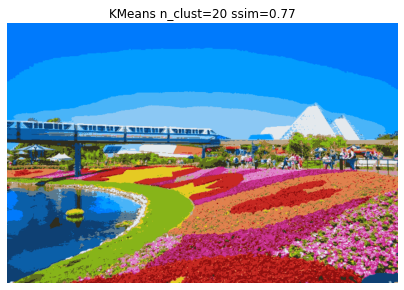

In [6]:
def run(stp,data):
    res = stp.copy()
    for i,d in enumerate(stp):

        if d['alg']=='KMeans':
            a = data.copy().reshape((data.shape[0]*data.shape[1],3))
            kmeans = KMeans(n_clusters=d['n_clusters'], random_state=0).fit(a)
            res[i]['num_clusters'] = d['n_clusters']
            df = pd.DataFrame(data.copy().reshape((data.shape[0]*data.shape[1],3)))
            for idx, cntr in enumerate(kmeans.cluster_centers_): 
                cntr_idx = np.sum(np.square(np.abs(a-cntr)),1).argmin()
                cntr_color = a[cntr_idx]
                df.loc[kmeans.labels_== idx, :] = cntr_color
            
        # if d['alg']=='AgglomerativeClustering':
        #     a = data.copy().reshape((data.shape[0]*data.shape[1],3))
        #     agl = AgglomerativeClustering(linkage="single", n_clusters=d['n_clusters']).fit(a)
        #     res[i]['num_clusters'] = agl.n_clusters_
        #     fl = data.copy().reshape((data.shape[0]*data.shape[1], 3))
        #     # b = fl.copy()
        #     for l in np.unique(agl.labels_):
        #         mean = np.mean(fl[np.where(agl.labels_ == l)], axis=(0,)).astype(int)
        #         fl[np.where(agl.labels_ == l)] = mean
        #     df = pd.DataFrame(fl)
            
        
        
        # calc SSIM
        res[i]['ssim'] = ssim(data, df.to_numpy().reshape((data.shape[0],data.shape[1], 3)), data_range=a.max() - a.min(),
            channel_axis=2 )
        # draw_picture(img, "img")
        draw_picture(df.to_numpy().reshape((data.shape[0],data.shape[1], 3)), "%s n_clust=%d ssim=%.02f" % (
            res[i]['alg'],
            res[i]['num_clusters'],
            res[i]['ssim'],
        ))

    return res

r= run(setup,img.copy())

Аггломеративная кластеризация работает очень долго и ест очень много памяти. Вообще не предназначен для даже таких небольших данных из-за своих ассимптотик: "By definition, the algorithm needs O(n²) memory and O(n³) runtime." https://datascience.stackexchange.com/questions/47889/how-to-run-agglomerativeclustering-on-a-big-data-in-python

С DBSCAN похожие проблемы. Поэтому оба этих алгоритма тестировались на сокращенных данных.

Если сравнивать алгоритмы KMeans и DBSCAN, скорость работы которых сравнима, то KMeans дает SIMM=0.77, на DBSCAN не удалось получить значения больше 0.5 (несмотря на бОльшее число кластеров у DBSCAN и сокращение данных для последнего). Итого, например для сжатия, KMeans эффективнее и качественнее. К тому же в реализации scikit он еще и быстрее (и менее ресурсоемкий), чем DBSCAN.
Проблему плохого SIMM у DBSCAN можно, наверное, решать начиная с обработки шумовых точек (которые DBSCAN не классифицировал).